In [1]:
#pip install git+https://github.com/ozgur/python-firebase
!pip install plotly

In [304]:
from firebase import firebase
import json
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import datetime
import missingno as msno
import tensorflow as tf
import IPython 
import IPython.display

In [3]:
my_firebase = firebase.FirebaseApplication('https://test-random-305921-default-rtdb.firebaseio.com/', None)

In [81]:
#list of all dates that we want to collect
start='2021-03-13'
end='2021-03-20'
l=pd.date_range(start,pd.to_datetime(end)-timedelta(days=1),freq='d')
print(l)

DatetimeIndex(['2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16',
               '2021-03-17', '2021-03-18', '2021-03-19'],
              dtype='datetime64[ns]', freq='D')


In [82]:
#extract the data
dates=[d.strftime('%Y-%m-%d') for d in l]
dall={}
for date in dates:
  trades=my_firebase.get('/websocket_trades_v1_'+date, '')
  dall.update(trades)

In [83]:
df=pd.DataFrame(dall).T.reset_index(drop=True)
df.head()

,best_ask,best_bid,high_24h,last_size,low_24h,open_24h,price,product_id,sequence,side,time,trade_id,type,volume_24h,volume_30d
0,57220.84,57220.83,58065.92,0.00026083,55050,57820.15,57220.84,BTC-USD,22644583792,buy,2021-03-13T00:00:00.228178Z,144186263,ticker,21749.34021998,732559.98070873
1,57229.81,57220.24,58065.92,0.01473,55050,57820.15,57229.48,BTC-USD,22644584012,buy,2021-03-13T00:00:00.594420Z,144186264,ticker,21749.35494998,732559.99543873
2,57229.81,57220.24,58065.92,0.00533154,55050,57820.15,57229.81,BTC-USD,22644584014,buy,2021-03-13T00:00:00.594420Z,144186265,ticker,21749.36028152,732560.00077027
3,57234.62,57222.71,58065.92,0.5,55050,57820.15,57223.11,BTC-USD,22644584238,sell,2021-03-13T00:00:00.770322Z,144186266,ticker,21749.86028152,732560.50077027
4,57234.62,57222.05,58065.92,0.0798435,55050,57820.15,57222.71,BTC-USD,22644584240,sell,2021-03-13T00:00:00.770322Z,144186267,ticker,21749.94012502,732560.58061377


In [84]:
df.shape

(3012554, 15)

In [87]:
#datatypes
df.time=pd.to_datetime(df.time)
df["price"] = df.price.astype(float)
df["last_size"] = df['last_size'].astype(float)
df["best_bid"] = df['best_bid'].astype(float)
df["best_ask"] = df['best_ask'].astype(float)

# Sharpe ratio

In [8]:
price=df[['price', 'time']]

In [9]:
price.head()

,price,time
0,57220.84,2021-03-13 00:00:00.228178+00:00
1,57229.48,2021-03-13 00:00:00.594420+00:00
2,57229.81,2021-03-13 00:00:00.594420+00:00
3,57223.11,2021-03-13 00:00:00.770322+00:00
4,57222.71,2021-03-13 00:00:00.770322+00:00


In [10]:
def abs_sharpe_ratio(price, time_agg):
    ohlc=price.resample(time_agg, on='time')['price'].ohlc()
    var=price.resample(time_agg, on='time')['price'].var()
    sharpe=(ohlc['high']-ohlc['low'])/var
    return(np.mean(sharpe))

In [11]:
def plot_abs_sharpe_ratio():
    x=np.arange(4, 62, 3)
    y=[]
    for el in x:
        time_agg=str(el)+'S'
        s=abs_sharpe_ratio(price, time_agg)
        y.append(s)
    plt.plot(x,y)


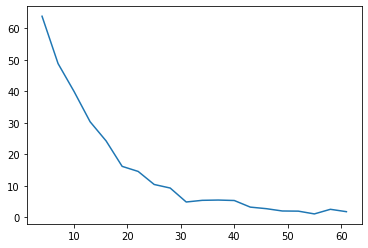

In [12]:
plot_abs_sharpe_ratio()

In [13]:
def sharpe_ratio(price, time_agg):
    last=price.resample(time_agg, on='time')['price'].last()
    first=price.resample(time_agg, on='time')['price'].first()
    var=price.resample(time_agg, on='time')['price'].var()
    sharpe=(last-first)/var
    return(np.mean(sharpe))

In [14]:
def plot_sharpe_ratio():
    x=np.arange(4, 500, 3)
    y=[]
    for el in x:
        time_agg=str(el)+'S'
        s=sharpe_ratio(price, time_agg)
        y.append(s)
    plt.plot(x,y)

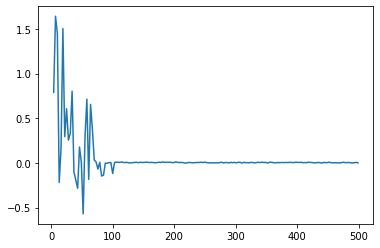

In [15]:
plot_sharpe_ratio()

# Test investment strat

In [86]:
def create_pre_sample_df(df):
    pre_sample_df=df.copy()
    pre_sample_df=pre_sample_df[['time', 'best_ask', 'best_bid', 'last_size', 'side', 'price' ]]
    #pre_sample_df['forward_mid_price_change']=(pre_sample_df['price'].diff(1).shift(-1))
    pre_sample_df['current_TFI'] = np.where(pre_sample_df['side'] == 'buy', pre_sample_df['last_size'], -pre_sample_df['last_size'])
    pre_sample_df['bid_ask_spread']=pre_sample_df['best_ask']-pre_sample_df['best_bid']
    return pre_sample_df

pre_sample_df=create_pre_sample_df(df)
pre_sample_df.head()

TypeError: bad operand type for unary -: 'str'

In [111]:
def create_post_sample_df(pre_sample_df, time_agg):
    post_sample_df=pre_sample_df.copy()
    post_sample_df=post_sample_df.resample(time_agg, on='time').agg(
    {
        'best_ask' : [np.mean,'first', 'max', 'min','last'],
        'best_bid' : [np.mean,'first', 'max', 'min','last'],
        'last_size': np.sum, 
        'side': ['count', lambda x: sum(x=='buy')],
        'price': [np.mean,'first', 'max', 'min','last'],
        #'forward_mid_price_change': np.sum,
        'current_TFI':np.sum,
        'bid_ask_spread': np.mean, 
        
    }
)
    post_sample_df.columns = ["_".join(x) for x in post_sample_df.columns.ravel()]
    post_sample_df.rename(columns={
        'side_<lambda_0>': 'buy_count',
        'last_size_sum':'volume'
    }
    , inplace=True)

    post_sample_df['mid_price']=(post_sample_df['price_min']+post_sample_df['price_max'])/2
    post_sample_df['forward_mid_price']=post_sample_df['mid_price'].shift(-1)
    return post_sample_df

post_sample_df=create_post_sample_df(pre_sample_df, '1Min')

In [112]:
post_sample_df

,best_ask_mean,best_ask_first,best_ask_max,best_ask_min,best_ask_last,best_bid_mean,best_bid_first,best_bid_max,best_bid_min,best_bid_last,...,buy_count,price_mean,price_first,price_max,price_min,price_last,current_TFI_sum,bid_ask_spread_mean,mid_price,forward_mid_price
time,,,,,,,,,,,,,,,,,,,,,
2021-03-13 00:00:00+00:00,57232.271349,57220.84,57290.68,57174.89,57174.89,57225.128893,57220.83,57282.44,57171.01,57174.88,...,143,57228.864948,57220.84,57290.68,57171.65,57174.89,-4.890432,7.142457,57231.165,57067.445
2021-03-13 00:01:00+00:00,57076.729831,57174.89,57174.89,56975.14,56976.06,57066.706898,57174.88,57174.88,56960.00,56960.52,...,146,57068.828026,57174.89,57174.89,56960.00,56960.52,-6.299339,10.022932,57067.445,56931.680
2021-03-13 00:02:00+00:00,56935.534776,56972.65,57043.88,56829.63,56990.92,56926.256948,56960.00,57018.55,56819.48,56971.83,...,282,56931.215386,56972.65,57043.88,56819.48,56990.92,4.386762,9.277828,56931.680,56884.895
2021-03-13 00:03:00+00:00,56855.263728,56973.28,56995.93,56779.23,56842.22,56845.078485,56973.27,56995.92,56773.86,56831.89,...,206,56849.669981,56973.28,56995.93,56773.86,56842.22,-4.687885,10.185243,56884.895,56834.570
2021-03-13 00:04:00+00:00,56835.577263,56844.86,56906.30,56774.86,56830.45,56827.525719,56835.08,56894.71,56762.85,56820.49,...,166,56831.713333,56844.86,56906.29,56762.85,56830.45,-1.064082,8.051544,56834.570,56863.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19 23:55:00+00:00,58028.530169,58053.84,58053.84,58002.01,58014.42,58026.107669,58053.83,58053.83,58002.00,58014.41,...,141,58027.628475,58053.83,58053.83,58002.01,58014.42,1.312489,2.422500,58027.920,58051.655
2021-03-19 23:56:00+00:00,58053.102629,58014.42,58091.12,58012.19,58077.98,58050.326150,58014.41,58091.11,58011.40,58077.97,...,172,58052.143756,58014.41,58091.12,58012.19,58077.98,5.162623,2.776479,58051.655,58124.305
2021-03-19 23:57:00+00:00,58124.114402,58077.97,58175.75,58072.90,58075.29,58120.926325,58077.96,58175.73,58067.47,58075.28,...,138,58122.973376,58077.96,58175.74,58072.87,58075.29,2.274128,3.188077,58124.305,58101.480


In [19]:
post_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2021-03-13 00:00:00+00:00 to 2021-03-13 23:59:00+00:00
Freq: T
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   best_ask_mean        1440 non-null   float64
 1   best_ask_first       1440 non-null   float64
 2   best_ask_max         1440 non-null   float64
 3   best_ask_min         1440 non-null   float64
 4   best_ask_last        1440 non-null   float64
 5   best_bid_mean        1440 non-null   float64
 6   best_bid_first       1440 non-null   float64
 7   best_bid_max         1440 non-null   float64
 8   best_bid_min         1440 non-null   float64
 9   best_bid_last        1440 non-null   float64
 10  volume               1440 non-null   float64
 11  side_count           1440 non-null   int64  
 12  buy_count            1440 non-null   int64  
 13  price_mean           1440 non-null   float64
 14  price_first          1440 non-nu

In [20]:
def ohlc_transformation(df, column, time_period):
    temp = df.resample(rule=time_period, on='time')[column].ohlc()
    return temp

In [21]:
def ohlc_viz(df_ohlc):
    #figure plot
    fig = go.Figure(data=[go.Candlestick(x=df_ohlc.index,
                open=df_ohlc.open,
                high=df_ohlc.high,
                low=df_ohlc.low,
                close=df_ohlc.close)])
    
    fig.show()

In [22]:
ohlc_viz(ohlc_transformation(df, column='price', time_period='Min'))

# LSTM with Data X structure

In [48]:
data=ohlc_transformation(df, column='price', time_period='Min')
data.head()

,open,high,low,close
time,,,,
2021-03-13 00:00:00+00:00,57220.84,57290.68,57171.65,57174.89
2021-03-13 00:01:00+00:00,57174.89,57174.89,56960.00,56960.52
2021-03-13 00:02:00+00:00,56972.65,57043.88,56819.48,56990.92
2021-03-13 00:03:00+00:00,56973.28,56995.93,56773.86,56842.22
2021-03-13 00:04:00+00:00,56844.86,56906.29,56762.85,56830.45


In [49]:
data['mid-price']=(data['high']+data['low'])/2

split_time=1000
x_train=data['mid-price'][:split_time]
time_train=data['mid-price'][:split_time].index
x_valid=data['mid-price'][split_time:]
time_valid=data['mid-price'][split_time:].index

In [50]:
x_train.head()

time
2021-03-13 00:00:00+00:00    57231.165
2021-03-13 00:01:00+00:00    57067.445
2021-03-13 00:02:00+00:00    56931.680
2021-03-13 00:03:00+00:00    56884.895
2021-03-13 00:04:00+00:00    56834.570
Freq: T, Name: mid-price, dtype: float64

In [74]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [75]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 10ms/step - loss: 56974.8713 - mae: 56975.3653
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 56970.0764 - mae: 56970.5746
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 56963.9280 - mae: 56964.4256
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 56956.9812 - mae: 56957.4800
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 56949.1583 - mae: 56949.6582
Epoch 6/100
33/33 [==============================] - 0s 9ms/step - loss: 56940.3409 - mae: 56940.8425
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 56930.4025 - mae: 56930.9003
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 56919.1909 - mae: 56919.6826
Epoch 9/100
33/33 [==============================] - 0s 10ms/step - loss: 56906.5402 - mae: 56907.0423
Epoch 10/100
33/33 [==============================] - 0s 10ms/step - loss: 

(1e-08, 0.0001, 0.0, 30.0)

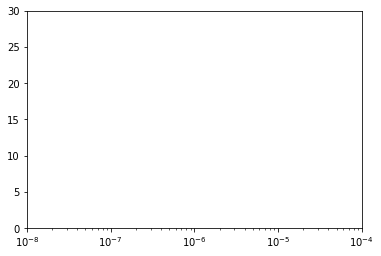

In [70]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [68]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = tf.keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
            #steps_per_epoch=25, validation_steps=5,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/100
33/33 [==============================] - 4s 36ms/step - loss: 56965.1657 - mae: 56965.6700 - val_loss: 60697.0078 - val_mae: 60697.5078
Epoch 2/100
33/33 [==============================] - 0s 13ms/step - loss: 56965.1607 - mae: 56965.6692 - val_loss: 60697.0039 - val_mae: 60697.5039
Epoch 3/100
33/33 [==============================] - 0s 13ms/step - loss: 56965.1544 - mae: 56965.6590 - val_loss: 60697.0039 - val_mae: 60697.4961
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 56965.1461 - mae: 56965.6433 - val_loss: 60696.9922 - val_mae: 60697.4844
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 56965.1373 - mae: 56965.6394 - val_loss: 60696.9805 - val_mae: 60697.4844
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 56965.1359 - mae: 56965.6320 - val_loss: 60696.9727 - val_mae: 60697.4727
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 56965.1286 - mae: 56965.6293 - val_los

In [71]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [72]:
rnn_forecast = model.predict(data['mid-price'][np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

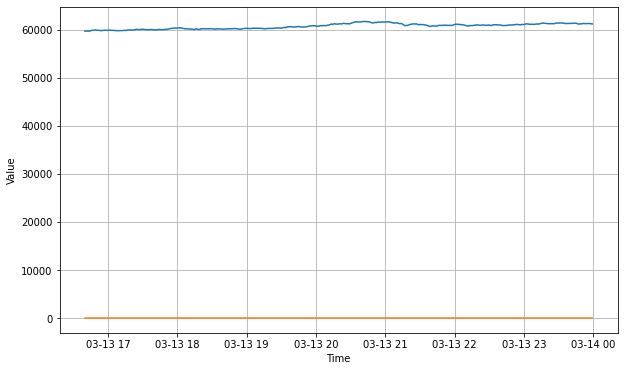

In [73]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [58]:

m=tf.keras.metrics.MeanAbsoluteError()

m.update_state(
    x_valid, rnn_forecast, sample_weight=None
)

m.result().numpy()

60523.63

# III. LSTM with Keras DOC
https://www.tensorflow.org/tutorials/structured_data/time_series

In [95]:
pre_sample_df=create_pre_sample_df(df)
post_sample_df=create_post_sample_df(pre_sample_df, '1Min')

In [96]:
pre_sample_df.head()

,time,best_ask,best_bid,last_size,side,price,current_TFI,bid_ask_spread
0,2021-03-13 00:00:00.228178+00:00,57220.84,57220.83,0.000261,buy,57220.84,0.000261,0.01
1,2021-03-13 00:00:00.594420+00:00,57229.81,57220.24,0.014730,buy,57229.48,0.014730,9.57
2,2021-03-13 00:00:00.594420+00:00,57229.81,57220.24,0.005332,buy,57229.81,0.005332,9.57
3,2021-03-13 00:00:00.770322+00:00,57234.62,57222.71,0.500000,sell,57223.11,-0.500000,11.91
4,2021-03-13 00:00:00.770322+00:00,57234.62,57222.05,0.079843,sell,57222.71,-0.079843,12.57


In [97]:
post_sample_df.head()

,best_ask_mean,best_ask_first,best_ask_max,best_ask_min,best_ask_last,best_bid_mean,best_bid_first,best_bid_max,best_bid_min,best_bid_last,...,side_count,buy_count,price_mean,price_first,price_max,price_min,price_last,current_TFI_sum,bid_ask_spread_mean,mid_price
time,,,,,,,,,,,,,,,,,,,,,
2021-03-13 00:00:00+00:00,57232.271349,57220.84,57290.68,57174.89,57174.89,57225.128893,57220.83,57282.44,57171.01,57174.88,...,289,143,57228.864948,57220.84,57290.68,57171.65,57174.89,-4.890432,7.142457,57231.165
2021-03-13 00:01:00+00:00,57076.729831,57174.89,57174.89,56975.14,56976.06,57066.706898,57174.88,57174.88,56960.00,56960.52,...,532,146,57068.828026,57174.89,57174.89,56960.00,56960.52,-6.299339,10.022932,57067.445
2021-03-13 00:02:00+00:00,56935.534776,56972.65,57043.88,56829.63,56990.92,56926.256948,56960.00,57018.55,56819.48,56971.83,...,557,282,56931.215386,56972.65,57043.88,56819.48,56990.92,4.386762,9.277828,56931.680
2021-03-13 00:03:00+00:00,56855.263728,56973.28,56995.93,56779.23,56842.22,56845.078485,56973.27,56995.92,56773.86,56831.89,...,515,206,56849.669981,56973.28,56995.93,56773.86,56842.22,-4.687885,10.185243,56884.895
2021-03-13 00:04:00+00:00,56835.577263,56844.86,56906.30,56774.86,56830.45,56827.525719,56835.08,56894.71,56762.85,56820.49,...,285,166,56831.713333,56844.86,56906.29,56762.85,56830.45,-1.064082,8.051544,56834.570


In [103]:
post_sample_df.shape

(10080, 21)

In [92]:
ohlc_viz(ohlc_transformation(df, column='price', time_period='Min'))

In [182]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

## III.1. Split training and testing data

In [183]:
column_indices = {name: i for i, name in enumerate(post_sample_df.columns)}

n = len(post_sample_df)
train_df = post_sample_df[0:int(n*0.7)]
val_df = post_sample_df[int(n*0.7):int(n*0.9)]
test_df = post_sample_df[int(n*0.9):]

num_features = df.shape[1]

In [184]:
train_df.shape

(7056, 22)

## III.2. Normalize

In [185]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

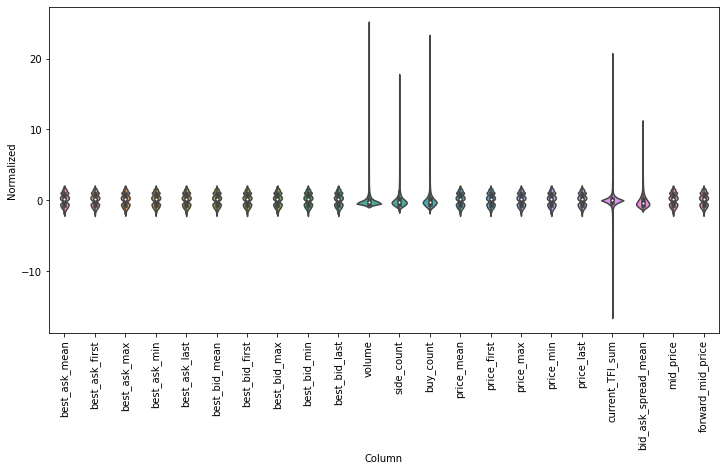

In [189]:
df_std = (post_sample_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(post_sample_df.keys(), rotation=90)

## Data Windowing

Window generator --> 

In [191]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [205]:
# for a 24h window into the future (shift) using 24h of data (input)
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['mid_price'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['mid_price']

In [271]:
# for a 1 hour prediction using 6 hours of data
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['mid_price'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['mid_price']

split window --> Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

The example w2, above, will be split like this:

The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs

In [281]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [282]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 22)
Inputs shape: (3, 6, 22)
labels shape: (3, 1, 1)


In [283]:
example_window.shape

TensorShape([3, 7, 22])

In [284]:
def plot(self, model=None, plot_col='mid_price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [min]')

WindowGenerator.plot = plot

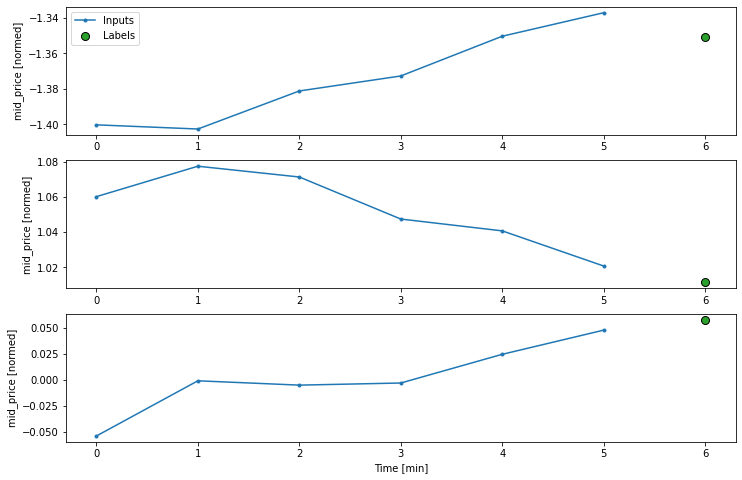

In [286]:
#w2.example = example_inputs, example_labels
w2.plot()

In [216]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [217]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [218]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 22), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

## Single Step Models

In [222]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['mid_price'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mid_price']

In [223]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 22)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline

In [224]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [258]:
baseline = Baseline(label_index=column_indices['mid_price'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 1ms/step - loss: 4.2396e-04 - mean_absolute_error: 0.0155


In [259]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['mid_price'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['mid_price']

In [260]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 22)
Output shape: (32, 24, 1)


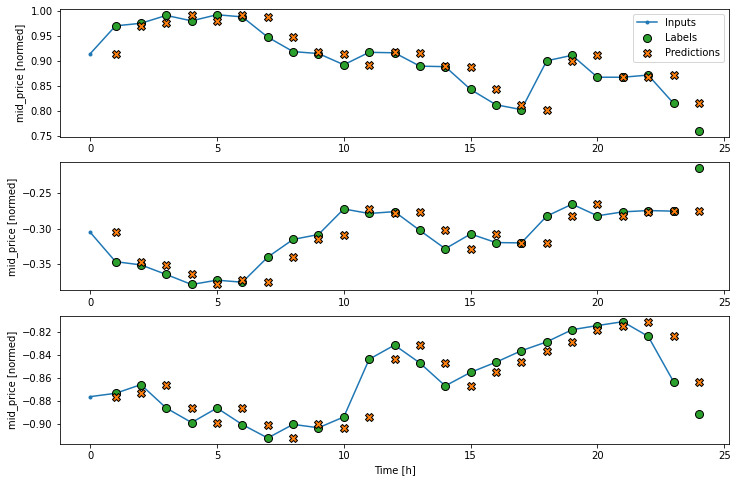

In [261]:
wide_window.plot(baseline)

## Linear

In [246]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [247]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 22)
Output shape: (32, 1, 1)


In [248]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [249]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
63/63 [==============================] - 0s 1ms/step - loss: nan - mean_absolute_error: nan


In [250]:
train_df.shape

(7056, 22)

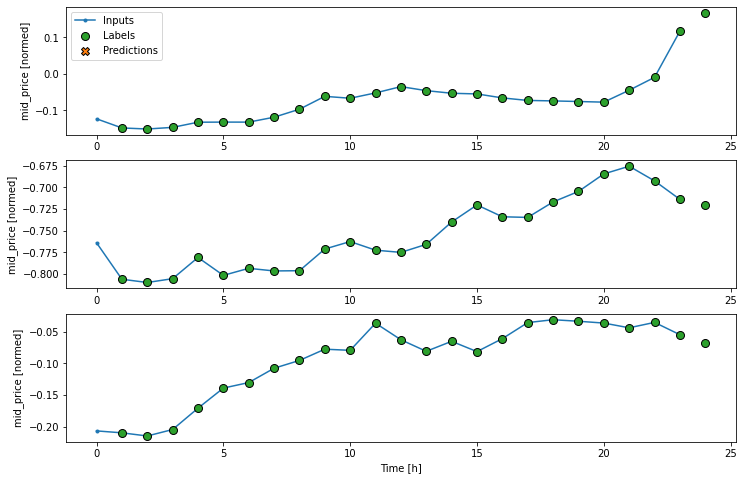

In [254]:
wide_window.plot(linear)

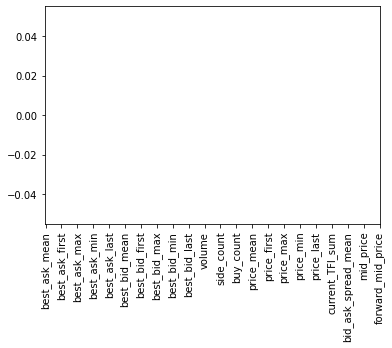

In [252]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [287]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
63/63 [==============================] - 0s 1ms/step - loss: nan - mean_absolute_error: nan


## Dense

In [292]:
tf.keras.backend.clear_session()

In [293]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
221/221 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
63/63 [==============================] - 0s 1ms/step - loss: nan - mean_absolute_error: nan


## Conv

In [298]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['mid_price'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['mid_price']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

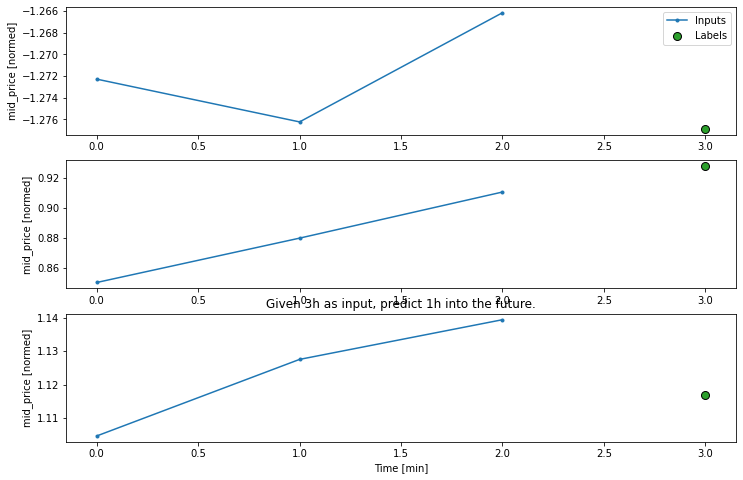

In [299]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

## Multistep dense

In [300]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [301]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 22)
Output shape: (32, 1, 1)


In [305]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan


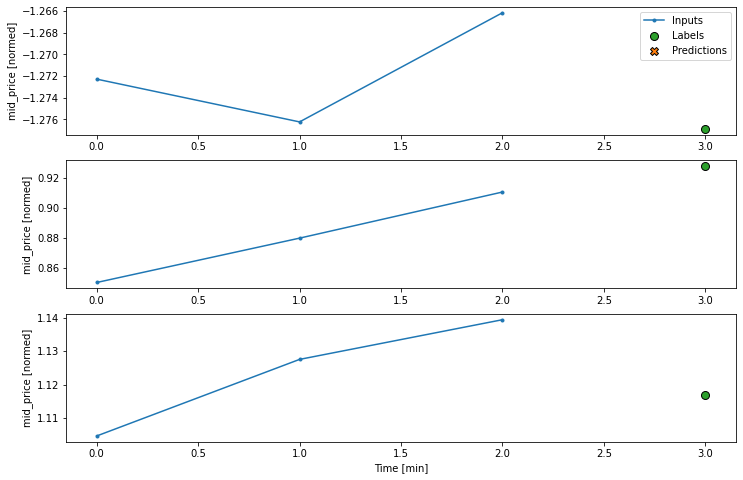

In [306]:
conv_window.plot(multi_step_dense)

## CNN

In [308]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [309]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 22)
Output shape: (32, 1, 1)


In [310]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan


In [311]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 22)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [313]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['mid_price'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['mid_price']

In [314]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 22)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


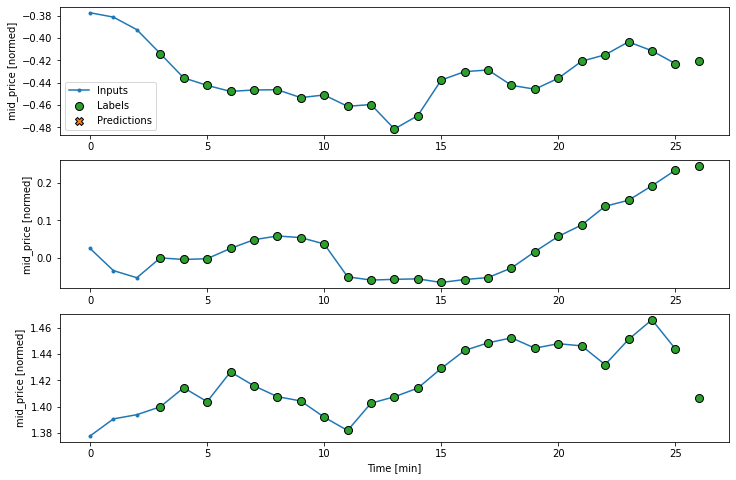

In [315]:
wide_conv_window.plot(conv_model)

## RNN/ LSTM

In [317]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [318]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 22)
Output shape: (32, 24, 1)


In [319]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

63/63 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


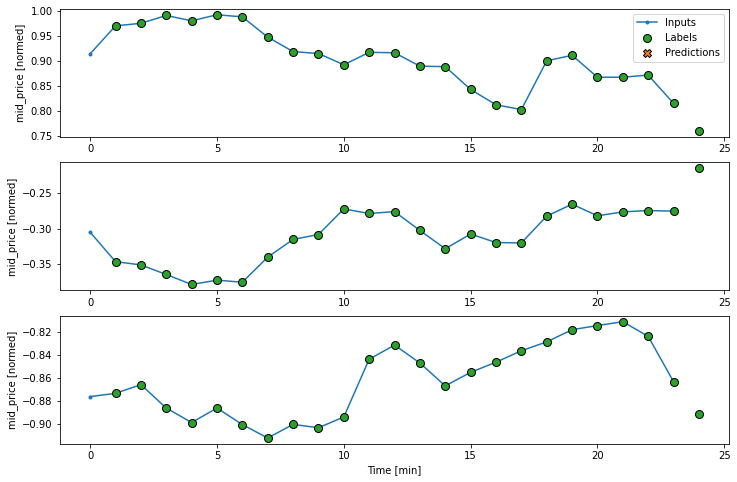

In [320]:
wide_window.plot(lstm_model)

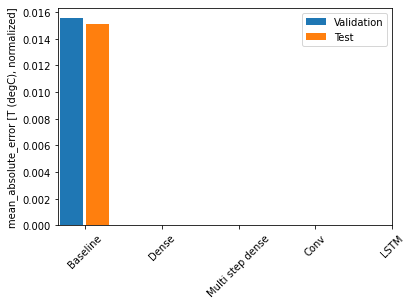

In [321]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()